# Poisson HMM Demo
## Applying an HMM to electrophysiology data from a motor-control task

In this notebook, we'll show how SSM can be used for modeling neuroscience data. This notebook is based off the 2008 paper ["Detecting Neural-State Transitions Using Hidden Markov Models for Motor Cortical Prostheses"](https://web.stanford.edu/~shenoy/GroupPublications/KemereEtAlJNeurophysiol2008.pdf) by Caleb Kemere _et al_.  

  
Kemere shows that an HMM can be used to detect neural transitions in a reaching task performed by a monkey. Crucially, by cleverly configuring the HMM states, the authors are also able to decode which target the monkey reached to using their trained HMM. See the paper for more details on the data and experimental set-up.
  
First, we need to load in the data. Though the data is not yet publicly available, we are hoping to make it available soon. We will assume that you have the dependencies included in SSM installed.

In [1]:
from scipy.linalg import block_diag
import autograd.numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ssm

%load_ext autoreload
# %autoreload 2

%matplotlib inline

## 1. Background

This dataset contains neural recordings made using a Utah array (96 electrodes) implanted in pre-motor cortex a macaque performing a reach task.
During the task, the monkey must reach to one of 8 targets, as indicated by a cue on a screen.
Each trial consists of 3 phases: a **baseline** phase, a **plan** phase, and a **move** phase.
We describe these phases below:

1. **baseline**: The animal fixates and places his hand in the center of the screen.
2. **plan**: A target appears in one of 8 locations (radially spread out from the center of the screen).
The monkey does not yet begin reaching.
3. **move**: A go-cue comes on, telling the monkey to begin his reach. Upon successfully reaching the target, the monkey receives a liquid reward.

The neural data has been spike-sorted and binned in 10ms intervals.  
  
**Note**: This data contains both single and multi-unit spiking activity. We'll be loose with terminology and use the term "neuron" and "unit" interchangeably here.

## 2. Load the dataset

The dataset is provided as a numpy .npz archive with the following variables:
  
1. `FR`: A numpy array of (neuron, time-bin, trial) with size (190, 155, 1127). The trials have already been time aligned, such that the plan and movement periods begin in the same time-bin for all of the 1127 trials.
2. `base_idx`: Indices of time-bins corresponding to the baseline period (see Section #1).
3. `plan_idx`: Indices of time-bins corresponding to the plan period.
4. `move_idx`: Indices of time-bins corresponding to the movement period.
5. `targets`: Length 8 list of the x,y coordinates for each of the 8 targets.
5. `target_idx`: A nested list, where `cInds[0]` is list of all trials to target 1, `cInds[1]` is a list of all trials to target 2, etc.
5. `train_idx`: Indices of the trials we will use for training.
5. `test_idx`: Indices of the trials we will use for testing.
  
  
Below, after we pull out the data, we visualize the spike data for the first trials.
We see that there is a noticeable increase in neural activity when the movement period starts.

In [2]:
DATA_PATH = "/Users/Bantin/Documents/Linderman-Shenoy/Kemere2008/extracted_data/H1217/H1217_hmm_data.npz"
vars_dict = np.load(DATA_PATH, allow_pickle=True)

In [3]:
FR = vars_dict['FR']
base_idx = vars_dict['base_idx']
plan_idx = vars_dict['plan_idx']
move_idx = vars_dict['move_idx']
targets = vars_dict['targets']
target_idx = vars_dict['target_idx']
train_idx = vars_dict['train_idx']
test_idx = vars_dict['test_idx']

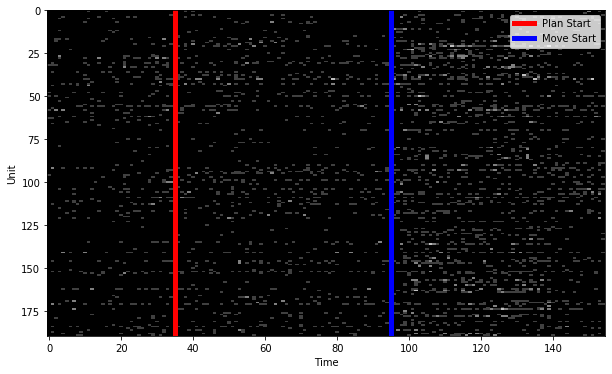

In [4]:
# Display a spike raster of the image
plt.figure(figsize=(10,6))
plt.imshow(FR[:,:,1], aspect='auto', cmap='gray')
#plt.axis('off')

# Label the different phases of the trial movement activity
time_bins = FR.shape[1]
plan_start = plan_idx[0]
move_start = move_idx[0]

plt.axvline(x=plan_start, color='red', linewidth=5, label='Plan Start')
plt.axvline(x=move_start, color='blue', linewidth=5, label='Move Start')
plt.ylabel("Unit")
plt.xlabel("Time")
plt.legend()
plt.tight_layout
plt.show()

## 3. Visualize the Targets
To get a sense of the task, we'll visualize the 8 targets used in the task. Inspecting the `targets` array, we see 
8 pairs of (x, y) coordinates. These correspond to the location of the 8 targets on the screen.

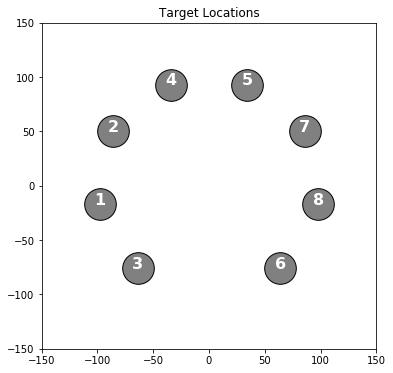

In [5]:
num_targets = len(targets)
xlist = [target[0] for target in targets]
ylist = [target[1] for target in targets]
plt.figure(figsize=(6,6))
plt.scatter(xlist,
            ylist,
            marker='o',
            s=10**3,
            edgecolors='black',
            facecolors='gray')
plt.xlim(-150, 150)
plt.ylim(-150, 150)

for i in range(num_targets):
    plt.annotate(str(i+1),
                 (xlist[i] - 5, ylist[i]),
                 color='white',
                 weight='bold',
                 size=16)
plt.title("Target Locations")
plt.show()

## 4. Fit a simple 3-state HMM
As a first step, we'll fit a simple 3 state HMM to the training data. For this, we're not aiming to actually decode which target the monkey reached to, we're merely going to check if we can uncover the the 3 phases of the reach (baseline, plan, move) in an unsupervised way using an HMM.
  
### 4.1 Format the data for SSM
When calling SSM's `fit` function, the data is expected to be formatted as a list `datas` where `datas[i]` is a 2D array of size `time_bins X observations`. Here, we'll reformat our data to match this. For us, this means that each entry of datas should be a `time_bins X 190`, because we have 190 neurons.


In order for the following steps to make sense, we need to give more details about how the `FR` array is arranged. As mentioned, it is formatted as (neurons, time, trials). However, not every trial in the dataset is actually the same length -- this is because the length of the delay period is randomized, and it takes the monkey varying amounts of time to reach the target.  

To acount for this, the `FR` array has been padded with NaNs so that all trials have the same length. This is very helpful, because it makes it easy to know which time bins correspond to each phase of the task. 
However, for our purposes, we don't want to include the NaNS when fitting our HMM (in fact, SSM will throw an error if we do). 
Instead, we will remove the columns of FR which contain NaNs, and create a list that matches the format above.

In [6]:
def format_spikes(FR, idx):
    datas = []
    for i in idx:
        spikes_cur = np.squeeze(FR[:,:,i])

        # remove columns which contain NaNs
        idx_keep = np.invert(np.any(np.isnan(spikes_cur), axis=0))
        spikes_cur = spikes_cur[:,idx_keep]

        # Transpose the data for passing to SSM fit function
        # To use the Poisson observation model, we must also
        # convert our arrays to be integer types.
        datas.append(np.asarray(spikes_cur.T, dtype=int))
    return datas

**Separate train and test**

The dataset has already been separated into train and test sets for us (this split is the same as was used in the original paper). For the below example, we are going to train and test only on **left and right** reaches, so we extract the indices for train and test reaches to the left and right. Below, we print some statistics on the number of trials for each condition.

**Note**: It's a bit weird to have the test set larger than the train set, but we are trying to follow the original methodology as closely as possible; the variables `train_idx` and `test_idx` are taken from the original MATLAB code (obtained via correspondence with the authors). In our case, fitting an HMM does not require much training data anyway, so 50 trials to each direction should suffice.

In [7]:
# We get the indices of all reaches to the left as target_inds[0]
# and all reaches to the right as target_inds[7]
left_reach_idx = set(target_idx[0])
right_reach_idx = set(target_idx[7])

train_right_idx = list(right_reach_idx.intersection(train_idx))
train_left_idx = list(left_reach_idx.intersection(train_idx))

test_right_idx = list(right_reach_idx.intersection(test_idx))
test_left_idx = list(left_reach_idx.intersection(test_idx))

train_idx_combined = train_right_idx + train_left_idx
test_idx_combined = test_right_idx + test_left_idx

train_datas = format_spikes(FR, train_idx_combined)
test_datas = format_spikes(FR, test_idx_combined)

print("Training set: "
      "Left reaches: {}, "
      "Right reaches: {}.".format(len(train_left_idx), len(train_right_idx))
     )
print("Test set: "
      "Left reaches: {}, "
      "Right reaches: {}.".format(len(test_left_idx), len(test_right_idx))
     )

Training set: Left reaches: 50, Right reaches: 50.
Test set: Left reaches: 77, Right reaches: 77.


### 4.2 Fit a simple 5-state HMM

**Creating the Initial State Distribution**  
By default, SSM will learn a distribution $\pi_0$ over the initial states. In our case, we want to tell SSM not to update the parameters of the initial state distribution during fitting. To do so we create an instance of the `FixedInitialStateDistribution` class as follows:
```python
# Manually set the initial state distribution
init_dist = ssm.init_state_distns.FixedInitialStateDistribution(num_states,
                                                                num_neurons,
                                                                pi0 = np.array([1, 0, 0, 0, 0]))
```
In the following sections, when we create an HMM object, we'll set its initial state distribution to the instance we just created.

**Initializing the mean firing rates for each state**  
Following the strategy outlined in the paper, we'd like to exploit our knowledge about the training set: namely, that we know when the target appears (stimulus onset) and when the go cue appears.

This information is given to us in the form of `base_idx`, `plan_idx`, and `move_idx` which are the indices for the "baseline", "plan", and "reach" epochs respectively. Recall that our dataset has been aligned so that the stimulus and go cue appear at the same time bin for each trial. In the below lines, we find the average firing rate (across all neurons) for each epoch, and store them to separate variables:


```python
lambdas_baseline = np.nanmean(FR[:,base_idx,:], axis=(1,2))
left_trials = FR[:,:,train_left_idx]
right_trials = FR[:,:,train_right_idx]

lambdas_plan_left = np.nanmean(left_trials[:,plan_idx,:], axis=(1,2))
lambdas_move_left = np.nanmean(left_trials[:,move_idx,:], axis=(1,2))

lambdas_plan_right = np.nanmean(right_trials[:,plan_idx,:], axis=(1,2))
lambdas_move_right = np.nanmean(right_trials[:,move_idx,:], axis=(1,2))

lambdas = np.vstack((lambdas_baseline,
                     lambdas_plan_right,
                     lambdas_move_right,
                     lambdas_plan_left,
                     lambdas_move_left))
```
Feel free to inspect the `lambdas` variables in a cell below. Each of `lambdas_baseline`, `lambdas_plan_right`, etc, is a vector of 190 entries, corresponding to the mean firing rate of that unit during that epoch. 

In this way, we are taking a semi-supervised approach: we are using external knowledge so that our HMM finds the structure we are expecting, but we still allow the mean firing rates to be adjusted by the EM algorithm during fitting.



**Setting the transition matrix and transition mask**   
For this, we'll replicate Figure 3 in the paper. We'll fit a simple 5 state HMM with 1 baseline state, and 2-states each for reaches to the left and right (plan and move). We will assign our states as follows:

0. Baseline
1. Planning Right
2. Reaching Right
3. Planning Left
4. Reaching Left

Following the approach used by Kemere _et al_, we want our HMM to be a "left to right" HMM -- there is no way of moving from "Plan Left" to "Move Right" for example. We also use the same initialization for the transition matrix $A$. Our initialization will be as follows:

$A = \begin{bmatrix}
0.8 & 0.1 & 0 & 0.1 & 0 \\
0   & 0.9 & 0.1 & 0 & 0 \\
0   & 0   & 1   & 0 & 0 \\
0   & 0   & 0 & 0.9 & 0.1\\
0   & 0   & 0  &   0 & 1
\end{bmatrix}$

In order to ensure that certain transitions are forbidden (i.e certain transition probabilities are zero), we will use the `constrained` transitions model when we instantiate the HMM. This transition model requires us to create a `transition_mask` which will tell SSM which entries of the transition matrix are allowed to be non-zero: entries which are 1 are allowed to change during fitting, and entries of the mask which are zero correspond to entries which are fixed at zeros.
  
In this case, we simply set the mask to be zero anywhere our initial transition matrix is zero:
```python
transition_mask = (A != 0)
transition_kwargs=dict(transition_mask=transition_mask)
```



Where $K$ is the number of discrete states, and $N$ is the dimensensionality of the observations. We'll use standard transitions and Poisson observations.
To fit our HMM to the training data, we call `HMM.fit(train_trials, masks=train_masks)`

In [8]:
num_states = 5
num_neurons = train_datas[0].shape[1]

# Manually set the initial state distribution
init_dist = ssm.init_state_distns.FixedInitialStateDistribution(num_states,
                                                                num_neurons,
                                                                pi0 = np.array([1, 0, 0, 0, 0]))


# Manually initialize the means for each state
lambdas_baseline = np.nanmean(FR[:,base_idx,:], axis=(1,2))
left_trials = FR[:,:,train_left_idx]
right_trials = FR[:,:,train_right_idx]

lambdas_plan_left = np.nanmean(left_trials[:,plan_idx,:], axis=(1,2))
lambdas_move_left = np.nanmean(left_trials[:,move_idx,:], axis=(1,2))

lambdas_plan_right = np.nanmean(right_trials[:,plan_idx,:], axis=(1,2))
lambdas_move_right = np.nanmean(right_trials[:,move_idx,:], axis=(1,2))

lambdas = np.vstack((lambdas_baseline,
                     lambdas_plan_right,
                     lambdas_move_right,
                     lambdas_plan_left,
                     lambdas_move_left))

# Manually initialize the transition probabilities
A = np.array(
[[0.8, 0.1, 0, 0.1, 0],
[0, 0.9, 0.1, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 0, 0.9, 0.1],
[0, 0, 0, 0, 1]]
)
transition_mask = (A != 0)
transition_kwargs=dict(transition_mask=transition_mask)

/Users/Bantin/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


**Create the HMM and Fit**

Below, we create a 5-state HMM, using the "constrained" transitions class and Poisson observations. In order to pass our transition mask to SSM, we wrap it in a dictionary called `transition_kwargs` which contains all keyword arguments that will be given to the transition model. 

We also set `init_state_distn=init_dist`, where `init_dist` is the initial state distribution object we created in the cell above.

We set the mean firing firing rates with `simple_hmm.log_lambdas = np.log(lambdas)` and the log transition matrices with `simple_hmm.transitions.log_Ps = np.log(A)`.  

Finally, we are ready to fit! We call `simple_hmm.fit` and store the resulting log-likelihoods to check convergence. Note that we see some RunTimeWarnings printed about dividing by zero. This is because certain transitions have zero probability, but SSM internally needs to take the log of the transition matrix. We can safely ignore these here. 


In [77]:
np.random.seed(seed=123)

# Create our HMM
simple_hmm = ssm.HMM(num_states,
                     num_neurons,
                     observations="poisson",
                     transitions="constrained",
                     transition_kwargs=transition_kwargs,
                     init_state_distn=init_dist)

simple_hmm.log_lambdas = np.log(lambdas)
simple_hmm.transitions.log_Ps = np.log(A)
lls = simple_hmm.fit(train_datas, method='em', num_iters=10)

/Users/Bantin/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


/Users/bantin/Documents/Linderman-Shenoy/ssm/ssm/messages.py:199: RuntimeWarning: divide by zero encountered in log
  _compute_stationary_expected_joints(alphas, betas, ll, np.log(Ps[0]), expected_joints)
/Users/Bantin/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


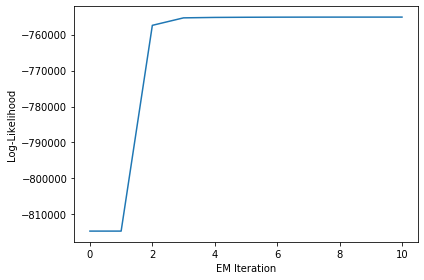

In [78]:
plt.figure(figsize=(6,4))
plt.plot(lls)
plt.xlabel("EM Iteration")
plt.ylabel("Log-Likelihood")
plt.tight_layout()

## 4.3 Visualize the posterior likelihood over the states

In [87]:
# get a random reach
test_trial_spikes = np.random.choice(test_datas)
posterior = simple_hmm.filter(test_trial_spikes)

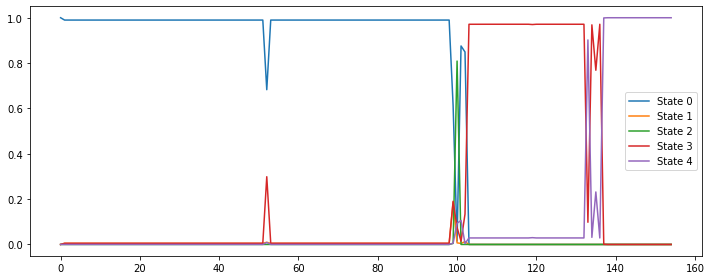

In [88]:
# plot posterior of states for a single test trial
plt.figure(figsize=(10, 4))
for i in range(num_states):
    plt.plot(posterior[:,i], label="State %d" % i)
plt.legend()
plt.tight_layout()

In [89]:
simple_hmm.most_likely_states(test_trial_spikes)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4])